In [1]:
from scipy import special
from scipy import optimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random as rand
from sam import greek
from datetime import date

In [2]:
def switch_freq(subj):
    i = subj[2]
    switcher = {
        'L':(10,15,20),
        'H':(25,30,35)
    }
    return switcher.get(i,"Error : Invalid subj ID")

In [3]:
MATLAB_drive = '/Users/clmn/MATLAB-Drive'
behav_dir = MATLAB_drive + '/TM experiment/TM_behavior/behav_data/'

In [4]:
subj = 'TML01_pilot'
f_ini, f_mid, f_fin = switch_freq(subj)
freq_range = range(f_ini,f_fin+1)
today = date.today().strftime("%Y%m%d")

## Psychometric Curve Fitting

In [5]:
def get_dataframe_DIS(subj):
    subj_behav_datum = behav_dir + subj + '/%s_Dis.dat' %subj
    df = pd.read_csv(subj_behav_datum, sep='\t', header=None)
    df.columns=['trial', 'Freq.1', 'ISI1', 'Freq.2', 'ISI2', 'decision', 'correctness', 'RT', 'ISI3']
#     df['Freq.1.class'] = [np.int64(np.sign(f-f_mid)) for f in df['Freq.1']]
#     df['Freq.2.class'] = [np.int64(np.sign(f-f_mid)) for f in df['Freq.2']]
#     df['Freq.other.index'] = [1 if a != 0 else 2 for a in df['Freq.1.class']]
#     df['Freq.other.class'] = [a+b for a, b in zip(df['Freq.1.class'], df['Freq.2.class'])]
    df['answer.index'] = [1 if a>b else 2 for a, b in zip(df['Freq.1'], df['Freq.2'])]
    df['decision.index'] = [1 if x == 'before' else (2 if x=='after' else 'NaN') for i, x in enumerate(df['decision'])]
#     df['Freq.other_decision.class'] = ['NaN' if b=='NaN' else (1 if a==b else -1) for a,b in zip(df['Freq.other.index'],df['decision.index'])]

    df['Freq.1.diff'] = [f-f_mid for f in df['Freq.1']]
    df['Freq.2.diff'] = [f-f_mid for f in df['Freq.2']]
    df['Freq.other.diff'] = [a+b for a, b in zip(df['Freq.1.diff'], df['Freq.2.diff'])]
    df['F1<F2.class'] = [np.sign(b-a) for a, b in zip(df['Freq.1'], df['Freq.2'])]
    df['F1<F2.diff'] = [b-a for a, b in zip(df['Freq.1'], df['Freq.2'])]

    return df

def scatter_x_y(subj):
    df = get_dataframe_DIS(subj)

    diff = np.arange(-5,6) # contrast
    ntrial_per_freq = int(len(df)*0.1)

    da = pd.DataFrame(index = ['prob'], columns = diff)

    for c in diff:
        temp = (df['decision.index'] != 'NaN') & (df['Freq.other.diff'] == c) & (df['answer.index'] == df['decision.index'])
        n = len(df[temp])
        da[c] = n * np.sign(c)
    da = (da/ntrial_per_freq + 1) * 0.5
    prob = np.array(da).reshape(len(diff))
    return diff+f_mid, prob

def func_ideal_observer(x, a,b,r,k):
    n = f_mid
    return 0.5*(1+special.erf( k/(a*k**r)**(0.5) * (x**b-n**b)/np.sqrt(x**(b*r)+n**(b*r)) ))

def func_error(x, mu,s):
    ## Error function
    ## 'mu' means mean
    ## 's' means deviation
    return 0.5*(1+special.erf((x-mu)/(np.sqrt(2)*s)))

def func_logistic(x, a,b):
    ## Logistic function
    ## freeparameter : a, b
    ## 'a' can be interpreted as the 75% threshold
    ## 'b' as a scaling factor that is inversely related to the slope of the psychometric function.
    return special.expit((x-a)/b)

def func_Weibull(x, a,b):
    ## Weibull cumulative distribution function
    ## 'a' summarises the effect of the stimulus
    ## 'b' reflets to the effect of noise
    g = 0.5 # chance level
    y = []
    for temp in x:
        k = temp - f_mid
        if k > 0:
            y.append(1 - (1-g)*np.exp(-a * (k**b)))
        elif k == 0:
            y.append(g)
        else:
            y.append(g*np.exp(-a * ((-k)**b))) # reverse Weibull cdf
    return np.asarray(y)

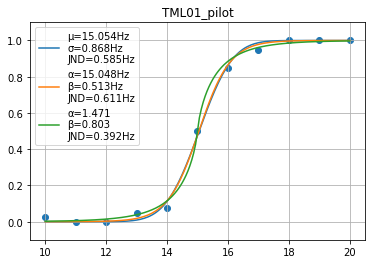

In [12]:
xdata, prob = scatter_x_y(subj)
dx = 2**(-4)
x = np.arange(f_ini,f_fin+dx,dx)

## error function
test_func = func_error
params, params_covariance = optimize.curve_fit(
    test_func, xdata, prob, maxfev=500,
    p0=[f_mid+5*(rand()-0.5),10*rand()]
)
JND=special.erfinv(0.5)*(np.sqrt(2)*params[1]); # JND for 75%
plt.plot(
    x, test_func(x, params[0],params[1]),
    label='%s=%.3fHz\n%s=%.3fHz\nJND=%.3fHz'%(greek('mu'),params[0],greek('sigma'),params[1],JND)
)

## logistic function
test_func = func_logistic
a_max, b_max = f_fin, 20.
params, params_covariance = optimize.curve_fit(
    test_func, xdata, prob, p0=[f_mid+5*(rand()-0.5),b_max*rand()], maxfev=500,
    bounds=([dx,dx], [a_max,b_max])
)
JND = params[1]*np.log(3)+params[0] - f_mid
plt.plot(x, test_func(x, params[0],params[1]), label='%s=%.3fHz\n%s=%.3fHz\nJND=%.3fHz'%(greek('alpha'),params[0],greek('beta'),params[1],JND))

## Weibull function
test_func = func_Weibull
a_max, b_max = 5., 2.
params, params_covariance = optimize.curve_fit(
    test_func, xdata, prob,
    p0=[a_max*rand(),b_max*rand()],
    maxfev=500,
    bounds=([dx,dx], [a_max,b_max])
)
JND = (np.log(2)/params[0])**(1./params[1])
plt.plot(
    x, test_func(x, params[0],params[1]),
    label='%s=%.3f\n%s=%.3f\nJND=%.3fHz'%(greek('alpha'),params[0],greek('beta'),params[1],JND)
)

plt.scatter(x=xdata,y=prob)
plt.legend(loc='best')
plt.ylim([-.1,1.1])

plt.title(subj)
plt.grid()
#plt.savefig(fname=today+'_'+subj+'_curve.png',dpi=300)

## Code test

In [1]:
from TM import curve_fit

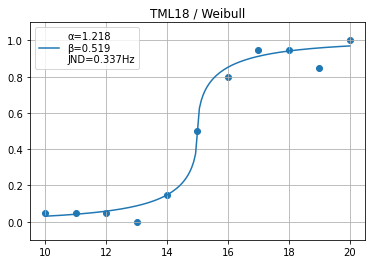

In [9]:
params = curve_fit('TML18',3)